# Radiomics to diagnose single brain tumors: GBM vs. Metastasis vs. Lymphoma

### *JBO, Chansik An, and Sung Soo Ahn*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Data cleaning



In [ ]:
import os
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import xgboost as xgb

In [ ]:
# load and dissect the dataset, and do some sanity checks
df = pd.read_csv('/content/drive/MyDrive/SC-MLSG/JBO-GLM/main_data(JBO).csv', 
                 index_col='id')

df_CE_T1 = df.filter(like='mask1_T1', axis=1)
df_CE_T2 = df.filter(like='mask1_T2', axis=1)
df_Peri_T1 = df.filter(like='mask2_T1', axis=1)
df_Peri_T2 = df.filter(like='mask2_T2', axis=1)
y = df['mask2_target']
print('Shapes of CE_T1, CE_T2, PeriT2_T1, PeriT2_T2, and y: \n',
      df_CE_T1.shape, df_CE_T2.shape, df_Peri_T1.shape, df_Peri_T2.shape, 
      y.shape, '\n')

print('Check if all the feature names are consistent:', 
  sorted([col_name.split('_', 2)[2] for col_name in df_CE_T1.columns]) == \
  sorted([col_name.split('_', 2)[2] for col_name in df_CE_T2.columns]) == \
  sorted([col_name.split('_', 2)[2] for col_name in df_Peri_T1.columns]) == \
  sorted([col_name.split('_', 2)[2] for col_name in df_Peri_T2.columns]), '\n'
)

# check redundant 'shape' features from T2 images
df_CE_T2_shape = df_CE_T2.filter(like='mask1_T2_shape')
df_Peri_T2_shape = df_Peri_T2.filter(like='mask2_T2_shape')

print('{0} shape features are redundant for CE and Peri T2 masks.'.
      format(df_CE_T2_shape.shape[1] + df_Peri_T2_shape.shape[1]))
print('Names of redundant shape features, from T2 images: \n',
      df_CE_T2_shape.columns.values + df_Peri_T2_shape.columns.values, '\n')

# datasets after excluding redudant shape features
df_CE_no_redundancy = pd.concat(
    [df_CE_T1, df_CE_T2.drop(df_CE_T2_shape.columns, axis=1)], axis=1)
df_Peri_no_redundancy = pd.concat(
    [df_Peri_T1, df_Peri_T2.drop(df_Peri_T2_shape.columns, axis=1)], axis=1)
print('Shapes of CE mask and PeriT2 mask datasets without redundancy:',
      df_CE_no_redundancy.shape, df_Peri_no_redundancy.shape, '\n')

# finalize the dataset
X = pd.concat([df_CE_no_redundancy, df_Peri_no_redundancy], axis=1)
print('Check if the indices of X and y are consistent in order:',
      np.mean(X.index == y.index) == 1)   
final_df = pd.concat([X, y], axis=1)

Shapes of CE_T1, CE_T2, PeriT2_T1, PeriT2_T2, and y: 
 (538, 93) (538, 93) (538, 93) (538, 93) (538,) 

Check if all the feature names are consistent: True 

28 shape features are redundant for CE and Peri T2 masks.
Names of redundant shape features, from T2 images: 
 ['mask1_T2_shape_Elongationmask2_T2_shape_Elongation'
 'mask1_T2_shape_Flatnessmask2_T2_shape_Flatness'
 'mask1_T2_shape_LeastAxisLengthmask2_T2_shape_LeastAxisLength'
 'mask1_T2_shape_MajorAxisLengthmask2_T2_shape_MajorAxisLength'
 'mask1_T2_shape_Maximum2DDiameterColumnmask2_T2_shape_Maximum2DDiameterColumn'
 'mask1_T2_shape_Maximum2DDiameterRowmask2_T2_shape_Maximum2DDiameterRow'
 'mask1_T2_shape_Maximum2DDiameterSlicemask2_T2_shape_Maximum2DDiameterSlice'
 'mask1_T2_shape_Maximum3DDiametermask2_T2_shape_Maximum3DDiameter'
 'mask1_T2_shape_MeshVolumemask2_T2_shape_MeshVolume'
 'mask1_T2_shape_MinorAxisLengthmask2_T2_shape_MinorAxisLength'
 'mask1_T2_shape_Sphericitymask2_T2_shape_Sphericity'
 'mask1_T2_shape_SurfaceAre

In [ ]:
X.head(10)

## 2) Exploratory data analysis

In [ ]:
# !pip install pandas-profiling==2.7.1

In [ ]:
from pandas_profiling import ProfileReport

X_selected = X.iloc[:100, :100]
prof = ProfileReport(X_selected)
prof.to_file(output_file='/content/drive/MyDrive/SC-MLSG/JBO-GLM/EDA_results.html')

Summarize dataset:   0%|          | 0/113 [00:00<?, ?it/s]

Currently, the number of features is 344 (172 for each mask). 

In [ ]:
[col_name.split('_', 2)[2] for col_name in df_CE_T1.columns]

In [ ]:
# 동일한 값들 제거

cor_set=[]
redundant_set=[]
plt.figure(figsize=(12,10))
cor = X.corr()
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        if cor.iloc[i,j] == 1.0:
            if not cor.index.tolist()[i] == cor.columns.tolist()[j]:
                cor_set.append((cor.index.tolist()[i],cor.columns.tolist()[j]))
                if not (cor.index.tolist()[j],cor.columns.tolist()[i]) in cor_set:
                    redundant_set.append((cor.index.tolist()[i],cor.columns.tolist()[j]))

for (i,j) in redundant_set:
    X.drop([j], axis=1, inplace=True)

NameError: ignored

<Figure size 864x720 with 0 Axes>

In [ ]:
X

,T2_firstorder_10Percentile,T2_firstorder_90Percentile,T2_firstorder_Energy,T2_firstorder_Entropy,T2_firstorder_InterquartileRange,T2_firstorder_Kurtosis,T2_firstorder_Maximum,T2_firstorder_Mean,T2_firstorder_MeanAbsoluteDeviation,T2_firstorder_Median,T2_firstorder_Minimum,T2_firstorder_Range,T2_firstorder_RobustMeanAbsoluteDeviation,T2_firstorder_RootMeanSquared,T2_firstorder_Skewness,T2_firstorder_Uniformity,T2_firstorder_Variance,T2_glcm_Autocorrelation,T2_glcm_ClusterProminence,T2_glcm_ClusterShade,T2_glcm_ClusterTendency,T2_glcm_Contrast,T2_glcm_Correlation,T2_glcm_DifferenceAverage,T2_glcm_DifferenceEntropy,T2_glcm_DifferenceVariance,T2_glcm_Id,T2_glcm_Idm,T2_glcm_Idmn,T2_glcm_Idn,T2_glcm_Imc1,T2_glcm_Imc2,T2_glcm_InverseVariance,T2_glcm_JointAverage,T2_glcm_JointEnergy,T2_glcm_JointEntropy,T2_glcm_MCC,T2_glcm_MaximumProbability,T2_glcm_SumAverage,T2_glcm_SumEntropy,...,T1C_glcm_SumAverage,T1C_glcm_SumEntropy,T1C_glcm_SumSquares,T1C_glszm_GrayLevelNonUniformity,T1C_glszm_GrayLevelNonUniformityNormalized,T1C_glszm_GrayLevelVariance,T1C_glszm_HighGrayLevelZoneEmphasis,T1C_glszm_LargeAreaEmphasis,T1C_glszm_LargeAreaHighGrayLevelEmphasis,T1C_glszm_LargeAreaLowGrayLevelEmphasis,T1C_glszm_LowGrayLevelZoneEmphasis,T1C_glszm_SizeZoneNonUniformity,T1C_glszm_SizeZoneNonUniformityNormalized,T1C_glszm_SmallAreaEmphasis,T1C_glszm_SmallAreaHighGrayLevelEmphasis,T1C_glszm_SmallAreaLowGrayLevelEmphasis,T1C_glszm_ZoneEntropy,T1C_glszm_ZonePercentage,T1C_glszm_ZoneVariance,T1C_glrlm_GrayLevelNonUniformity,T1C_glrlm_GrayLevelNonUniformityNormalized,T1C_glrlm_GrayLevelVariance,T1C_glrlm_HighGrayLevelRunEmphasis,T1C_glrlm_LongRunEmphasis,T1C_glrlm_LongRunHighGrayLevelEmphasis,T1C_glrlm_LongRunLowGrayLevelEmphasis,T1C_glrlm_LowGrayLevelRunEmphasis,T1C_glrlm_RunEntropy,T1C_glrlm_RunLengthNonUniformity,T1C_glrlm_RunLengthNonUniformityNormalized,T1C_glrlm_RunPercentage,T1C_glrlm_RunVariance,T1C_glrlm_ShortRunEmphasis,T1C_glrlm_ShortRunHighGrayLevelEmphasis,T1C_glrlm_ShortRunLowGrayLevelEmphasis,T1C_ngtdm_Busyness,T1C_ngtdm_Coarseness,T1C_ngtdm_Complexity,T1C_ngtdm_Contrast,T1C_ngtdm_Strength
0,-27.055314,356.797906,4.410430e+09,2.400321,217.036303,3.624453,1022.311768,75.696213,140.572606,-27.009237,-223.051117,1245.362885,100.847688,182.586545,1.343446,0.400582,27607.929685,87.898372,15325.636646,704.843185,66.078419,2.103150,0.938311,0.593156,1.446336,1.734569,0.823618,0.806587,0.998032,0.983216,-0.481361,0.949069,0.184059,8.479647,0.350560,3.684919,0.971661,0.589186,16.959295,2.901693,...,23.488126,5.069641,19.541046,243.363636,0.056439,24.840740,278.146568,1.781540e+05,2.399236e+07,1761.237471,0.007450,1579.910019,0.366398,0.628756,181.903139,0.004540,6.559425,0.032594,1.772127e+05,5375.810646,0.062197,20.462298,175.365837,3.549080,499.320816,0.046100,0.010288,5.536170,45550.025196,0.523427,0.653134,1.158069,0.750607,139.039406,0.007147,11.500942,0.000216,280.628373,0.024424,0.101816
1,214.392715,357.957520,2.611016e+09,3.577562,76.179596,4.710394,583.554932,282.198975,46.136255,276.096954,-41.821037,625.375969,31.474776,288.450570,0.535920,0.100048,3567.469754,299.382937,2939.756140,81.355549,27.877683,2.718773,0.821351,1.029371,1.824795,1.623047,0.623948,0.593268,0.997529,0.970081,-0.310499,0.932282,0.480399,17.119950,0.025358,5.847495,0.895158,0.051066,34.239900,4.393218,...,29.952139,4.495002,8.308378,115.803465,0.062698,23.274337,295.694099,3.741239e+04,9.013654e+06,164.859818,0.010836,769.685436,0.416722,0.670634,200.839141,0.005034,6.112713,0.058857,3.712372e+04,1955.023457,0.091971,10.313815,242.888947,3.233066,734.966406,0.018259,0.006388,4.992386,11722.150495,0.547230,0.677036,1.003004,0.766850,190.630583,0.005130,2.486269,0.000587,304.316805,0.012197,0.299328
2,115.840350,313.899652,5.332207e+09,3.721719,111.207581,5.196986,664.935913,200.404388,65.036512,181.936340,-21.909529,686.845442,46.046362,216.812228,1.271018,0.093868,6845.623475,127.799447,14660.451889,480.281078,53.893883,2.859503,0.898972,0.998501,1.910608,1.809931,0.66

In [ ]:
np.random.seed(42)
shuffled_indices=np.random.permutation(X.shape[0])
test_size=int(0.3*X.shape[0])
test_indices=shuffled_indices[:test_size]
train_indices=shuffled_indices[test_size:]
X_train=X.iloc[train_indices]
y_train=y.iloc[train_indices]
X_val=X.iloc[test_indices]
y_val=y.iloc[test_indices]

features_names=X.columns.tolist()

In [ ]:
X_train

,T2_firstorder_10Percentile,T2_firstorder_90Percentile,T2_firstorder_Energy,T2_firstorder_Entropy,T2_firstorder_InterquartileRange,T2_firstorder_Kurtosis,T2_firstorder_Maximum,T2_firstorder_Mean,T2_firstorder_MeanAbsoluteDeviation,T2_firstorder_Median,T2_firstorder_Minimum,T2_firstorder_Range,T2_firstorder_RobustMeanAbsoluteDeviation,T2_firstorder_RootMeanSquared,T2_firstorder_Skewness,T2_firstorder_Uniformity,T2_firstorder_Variance,T2_glcm_Autocorrelation,T2_glcm_ClusterProminence,T2_glcm_ClusterShade,T2_glcm_ClusterTendency,T2_glcm_Contrast,T2_glcm_Correlation,T2_glcm_DifferenceAverage,T2_glcm_DifferenceEntropy,T2_glcm_DifferenceVariance,T2_glcm_Id,T2_glcm_Idm,T2_glcm_Idmn,T2_glcm_Idn,T2_glcm_Imc1,T2_glcm_Imc2,T2_glcm_InverseVariance,T2_glcm_JointAverage,T2_glcm_JointEnergy,T2_glcm_JointEntropy,T2_glcm_MCC,T2_glcm_MaximumProbability,T2_glcm_SumAverage,T2_glcm_SumEntropy,...,T1C_glcm_SumAverage,T1C_glcm_SumEntropy,T1C_glcm_SumSquares,T1C_glszm_GrayLevelNonUniformity,T1C_glszm_GrayLevelNonUniformityNormalized,T1C_glszm_GrayLevelVariance,T1C_glszm_HighGrayLevelZoneEmphasis,T1C_glszm_LargeAreaEmphasis,T1C_glszm_LargeAreaHighGrayLevelEmphasis,T1C_glszm_LargeAreaLowGrayLevelEmphasis,T1C_glszm_LowGrayLevelZoneEmphasis,T1C_glszm_SizeZoneNonUniformity,T1C_glszm_SizeZoneNonUniformityNormalized,T1C_glszm_SmallAreaEmphasis,T1C_glszm_SmallAreaHighGrayLevelEmphasis,T1C_glszm_SmallAreaLowGrayLevelEmphasis,T1C_glszm_ZoneEntropy,T1C_glszm_ZonePercentage,T1C_glszm_ZoneVariance,T1C_glrlm_GrayLevelNonUniformity,T1C_glrlm_GrayLevelNonUniformityNormalized,T1C_glrlm_GrayLevelVariance,T1C_glrlm_HighGrayLevelRunEmphasis,T1C_glrlm_LongRunEmphasis,T1C_glrlm_LongRunHighGrayLevelEmphasis,T1C_glrlm_LongRunLowGrayLevelEmphasis,T1C_glrlm_LowGrayLevelRunEmphasis,T1C_glrlm_RunEntropy,T1C_glrlm_RunLengthNonUniformity,T1C_glrlm_RunLengthNonUniformityNormalized,T1C_glrlm_RunPercentage,T1C_glrlm_RunVariance,T1C_glrlm_ShortRunEmphasis,T1C_glrlm_ShortRunHighGrayLevelEmphasis,T1C_glrlm_ShortRunLowGrayLevelEmphasis,T1C_ngtdm_Busyness,T1C_ngtdm_Coarseness,T1C_ngtdm_Complexity,T1C_ngtdm_Contrast,T1C_ngtdm_Strength
290,167.438977,203.469052,5.816525e+08,2.779074,19.620415,7.708519,365.719971,184.481944,11.592146,183.019089,86.895088,278.824883,8.075810,185.086925,0.935934,0.172538,223.582444,140.571224,509.980575,21.509672,10.022851,1.816672,0.693335,0.872851,1.699705,1.033078,0.660959,0.638172,0.998267,0.974323,-0.220213,0.826347,0.476510,11.769427,0.049007,4.932157,0.746623,0.099072,23.538854,3.655173,...,30.977325,4.351110,7.248944,27.502488,0.068414,20.552288,306.179104,5.997095e+04,1.456969e+07,270.237821,0.007460,131.233831,0.326452,0.592231,188.515713,0.005611,6.123103,0.023676,5.818705e+04,914.353114,0.096629,8.186367,246.134447,5.089267,1271.210545,0.023130,0.004815,5.256873,3890.254346,0.405311,0.557268,1.746977,0.654146,160.210483,0.003236,1.266626,0.001328,193.976569,0.009879,0.599608
42,159.175909,252.909412,4.016242e+08,4.114652,50.529419,3.214683,383.868866,204.787029,29.836238,202.342010,101.790344,282.078522,20.942237,208.158175,0.350785,0.067329,1392.098916,170.494208,9946.199234,69.158747,56.676199,7.604456,0.762210,2.055050,2.589675,3.237139,0.453324,0.380870,0.992834,0.942185,-0.186317,0.864309,0.382439,12.578559,0.008776,7.328927,0.776982,0.017138,25.157118,4.946617,...,36.545070,4.310789,7.842971,72.219338,0.064655,21.096305,326.485228,3.291279e+03,1.190724e+06,9.268259,0.006803,351.839749,0.314986,0.581652,195.599652,0.005047,6.520497,0.120509,3.222421e+03,778.300921,0.100701,9.543246,342.100415,1.702567,586.018657,0.005945,0.003761,4.357715,5593.467443,0.722392,0.833855,0.259250,0.874552,298.573856,0.003367,1.103748,0.001092,512.463136,0.021813,0.561925
349,259.846613,420.847986,1.145920e+10,3.947271,81.160049,2.979867,679.984985,344.543568,49.174081,349.034973,157.966370,522.018616,34.174911,350.055245,0.060568,0.076118,3828.404104,161.491192,7907.808339,17.860521,51.621421,2.922432,0.892537,1.164100,2.018923,1.517955,0.602808,0.564794,0.99719

In [ ]:
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
X_train

array([[-0.36113736, -1.79777935, -1.12825468, ..., -1.24696343,
        -0.28002246,  0.97123465],
       [-0.50881544, -1.18513981, -1.16447402, ...,  2.04638474,
         0.71729554,  0.85839877],
       [ 1.29037782,  0.89586877,  1.06016599, ..., -0.01063503,
        -0.52996651, -0.13738295],
       ...,
       [ 0.89039219,  0.72724509,  1.32559366, ..., -0.55416305,
        -0.49129563, -0.36489171],
       [ 0.37360139,  0.15788942,  1.4499327 , ..., -0.25616863,
         0.07024011, -0.59575409],
       [ 0.85220835,  0.47742266,  0.89338337, ..., -0.24769351,
         0.22619154, -0.48173443]])

In [ ]:
# MI

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils import resample

a=[i for i in range(X_train.shape[0])]
np.random.seed(42)
scores_MI=pd.DataFrame([])

fs = SelectKBest(mutual_info_classif)

for k in range(1000):
    select=np.random.choice(a, size=X_train.shape[0])
    X_chosen=X_train[select,:]
    y_chosen=np.array(y_train.iloc[select])
    fs.fit(X_chosen, y_chosen)
    s=pd.DataFrame(fs.scores_).T
    scores_MI=scores_MI.append(s,ignore_index=True)
    print(k, end=' / ')


0 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 20 / 21 / 22 / 23 / 24 / 25 / 26 / 27 / 28 / 29 / 30 / 31 / 32 / 33 / 34 / 35 / 36 / 37 / 38 / 39 / 40 / 41 / 42 / 43 / 44 / 45 / 46 / 47 / 48 / 49 / 50 / 51 / 52 / 53 / 54 / 55 / 56 / 57 / 58 / 59 / 60 / 61 / 62 / 63 / 64 / 65 / 66 / 67 / 68 / 69 / 70 / 71 / 72 / 73 / 74 / 75 / 76 / 77 / 78 / 79 / 80 / 81 / 82 / 83 / 84 / 85 / 86 / 87 / 88 / 89 / 90 / 91 / 92 / 93 / 94 / 95 / 96 / 97 / 98 / 99 / 100 / 101 / 102 / 103 / 104 / 105 / 106 / 107 / 108 / 109 / 110 / 111 / 112 / 113 / 114 / 115 / 116 / 117 / 118 / 119 / 120 / 121 / 122 / 123 / 124 / 125 / 126 / 127 / 128 / 129 / 130 / 131 / 132 / 133 / 134 / 135 / 136 / 137 / 138 / 139 / 140 / 141 / 142 / 143 / 144 / 145 / 146 / 147 / 148 / 149 / 150 / 151 / 152 / 153 / 154 / 155 / 156 / 157 / 158 / 159 / 160 / 161 / 162 / 163 / 164 / 165 / 166 / 167 / 168 / 169 / 170 / 171 / 172 / 173 / 174 / 175 / 176 / 177 / 178 / 179 / 180 / 181 / 182 / 183 / 184 / 

In [ ]:

result_MI=scores_MI.describe().iloc[1:3,:]
result_MI.columns=features_names
print(result_MI.T)
result_MI.T.to_csv('feature_select_result_MI.csv')

                                      mean       std
T2_firstorder_10Percentile        0.206942  0.044305
T2_firstorder_90Percentile        0.216587  0.043522
T2_firstorder_Energy              0.193893  0.042693
T2_firstorder_Entropy             0.217088  0.043643
T2_firstorder_InterquartileRange  0.211525  0.042555
...                                    ...       ...
T1C_ngtdm_Busyness                0.190211  0.042808
T1C_ngtdm_Coarseness              0.124460  0.037034
T1C_ngtdm_Complexity              0.223452  0.043064
T1C_ngtdm_Contrast                0.225418  0.042859
T1C_ngtdm_Strength                0.237643  0.043846

[170 rows x 2 columns]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('fs', SelectKBest(mutual_info_classif)),
                 ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=0.5))])

param_grid = {'fs__k': [30,50,70,90],'clf__n_estimators': [50, 100, 200]}

mi_Ada = GridSearchCV(pipe, param_grid, cv=5)
mi_Ada.fit(X_train, y_train)
print(mi_Ada.best_estimator_)

C:\Users\Bio\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
         steps=[('fs',
                 SelectKBest(k=90,
                             score_func=<function mutual_info_classif at 0x0000015DB10EF708>)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=1,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_impurity_split=None,
                                                                          min_sampl

In [ ]:

selected_features_MI=list(scores_MI.describe().loc['mean'].sort_values(ascending=[False]).head(90).index)
print(selected_features_MI)
selected_features_name_MI=[]
for i in selected_features_MI:
    selected_features_name_MI.append(features_names[i])
print(selected_features_name_MI)

[35, 88, 67, 10, 14, 70, 11, 34, 38, 33, 37, 25, 135, 26, 63, 133, 12, 15, 141, 120, 24, 97, 27, 16, 6, 99, 129, 90, 28, 64, 36, 162, 134, 93, 83, 60, 7, 23, 104, 79, 100, 19, 169, 68, 111, 71, 105, 13, 150, 65, 58, 124, 54, 115, 140, 21, 114, 29, 102, 41, 61, 122, 145, 96, 107, 76, 49, 87, 121, 62, 75, 103, 168, 84, 5, 113, 40, 50, 101, 82, 159, 153, 167, 127, 155, 147, 143, 20, 146, 91]
['T2_glcm_JointEntropy', 'T2_shape_Sphericity', 'T2_glrlm_RunLengthNonUniformityNormalized', 'T2_firstorder_Minimum', 'T2_firstorder_Skewness', 'T2_glrlm_ShortRunEmphasis', 'T2_firstorder_Range', 'T2_glcm_JointEnergy', 'T2_glcm_SumAverage', 'T2_glcm_JointAverage', 'T2_glcm_MaximumProbability', 'T2_glcm_DifferenceVariance', 'T1C_glszm_GrayLevelVariance', 'T2_glcm_Id', 'T2_glrlm_LongRunLowGrayLevelEmphasis', 'T1C_glszm_GrayLevelNonUniformity', 'T2_firstorder_RobustMeanAbsoluteDeviation', 'T2_firstorder_Uniformity', 'T1C_glszm_SizeZoneNonUniformity', 'T1C_glcm_Idmn', 'T2_glcm_DifferenceEntropy', 'T1C_fir

In [ ]:

y_pred=mi_Ada.predict(X_val)
accuracy_score(y_val, y_pred)

0.6219512195121951

In [ ]:
# F-score
from sklearn.feature_selection import f_classif

a=[i for i in range(X_train.shape[0])]
np.random.seed(42)
scores_F=pd.DataFrame([])

fs= SelectKBest(f_classif)

for k in range(1000):
    select=np.random.choice(a, size=X_train.shape[0])
    X_chosen=X_train[select,:]
    y_chosen=np.array(y_train.iloc[select])
    fs.fit(X_chosen, y_chosen)
    s=pd.DataFrame(fs.scores_).T
    scores_F=scores_F.append(s,ignore_index=True)
    print(k, end=' / ')

result_F=scores_F.describe().iloc[1:3,:]
result_F.columns=features_names
print(result_F.T)
result_F.T.to_csv('feature_select_result_Fscore.csv')


0 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 20 / 21 / 22 / 23 / 24 / 25 / 26 / 27 / 28 / 29 / 30 / 31 / 32 / 33 / 34 / 35 / 36 / 37 / 38 / 39 / 40 / 41 / 42 / 43 / 44 / 45 / 46 / 47 / 48 / 49 / 50 / 51 / 52 / 53 / 54 / 55 / 56 / 57 / 58 / 59 / 60 / 61 / 62 / 63 / 64 / 65 / 66 / 67 / 68 / 69 / 70 / 71 / 72 / 73 / 74 / 75 / 76 / 77 / 78 / 79 / 80 / 81 / 82 / 83 / 84 / 85 / 86 / 87 / 88 / 89 / 90 / 91 / 92 / 93 / 94 / 95 / 96 / 97 / 98 / 99 / 100 / 101 / 102 / 103 / 104 / 105 / 106 / 107 / 108 / 109 / 110 / 111 / 112 / 113 / 114 / 115 / 116 / 117 / 118 / 119 / 120 / 121 / 122 / 123 / 124 / 125 / 126 / 127 / 128 / 129 / 130 / 131 / 132 / 133 / 134 / 135 / 136 / 137 / 138 / 139 / 140 / 141 / 142 / 143 / 144 / 145 / 146 / 147 / 148 / 149 / 150 / 151 / 152 / 153 / 154 / 155 / 156 / 157 / 158 / 159 / 160 / 161 / 162 / 163 / 164 / 165 / 166 / 167 / 168 / 169 / 170 / 171 / 172 / 173 / 174 / 175 / 176 / 177 / 178 / 179 / 180 / 181 / 182 / 183 / 184 / 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('fs', SelectKBest(f_classif)),
                 ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=0.5))])

param_grid = {'fs__k': [30,50,70,90],'clf__n_estimators': [50, 100, 200]}

F_Ada = GridSearchCV(pipe, param_grid, cv=5)
F_Ada.fit(X_train, y_train)
print(F_Ada.best_estimator_)


C:\Users\Bio\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
         steps=[('fs',
                 SelectKBest(k=70,
                             score_func=<function f_classif at 0x0000015DB0DCA558>)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=1,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_impurity_split=None,
                                                                          min_samples_leaf=1,

In [ ]:
selected_features_F=list(scores_F.describe().loc['mean'].sort_values(ascending=[False]).head(90).index)
print(selected_features_F)
selected_features_name_F=[]
for i in selected_features_F:
    selected_features_name_F.append(features_names[i])
print(selected_features_name_F)

y_pred=F_Ada.predict(X_val)
accuracy_score(y_val, y_pred)

[135, 88, 29, 23, 27, 26, 133, 28, 24, 21, 75, 35, 141, 71, 17, 33, 38, 97, 60, 76, 25, 3, 39, 19, 9, 68, 67, 146, 80, 106, 40, 52, 14, 90, 20, 70, 0, 10, 89, 102, 140, 7, 50, 134, 44, 30, 51, 145, 53, 147, 142, 36, 11, 59, 13, 148, 41, 48, 96, 104, 37, 124, 79, 143, 15, 66, 169, 6, 107, 110, 95, 100, 164, 92, 131, 101, 93, 129, 58, 156, 1, 105, 83, 43, 99, 165, 64, 150, 87, 34]
['T1C_glszm_GrayLevelVariance', 'T2_shape_Sphericity', 'T2_glcm_Idn', 'T2_glcm_DifferenceAverage', 'T2_glcm_Idm', 'T2_glcm_Id', 'T1C_glszm_GrayLevelNonUniformity', 'T2_glcm_Idmn', 'T2_glcm_DifferenceEntropy', 'T2_glcm_Contrast', 'T2_ngtdm_Complexity', 'T2_glcm_JointEntropy', 'T1C_glszm_SizeZoneNonUniformity', 'T2_glrlm_ShortRunHighGrayLevelEmphasis', 'T2_glcm_Autocorrelation', 'T2_glcm_JointAverage', 'T2_glcm_SumAverage', 'T1C_firstorder_Kurtosis', 'T2_glrlm_HighGrayLevelRunEmphasis', 'T2_ngtdm_Contrast', 'T2_glcm_DifferenceVariance', 'T2_firstorder_Entropy', 'T2_glcm_SumEntropy', 'T2_glcm_ClusterShade', 'T2_fi

0.6158536585365854

In [ ]:
#RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Ada=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=0.5, n_estimators=200)
rfe = RFECV(estimator=Ada, step=1, cv=5)

rfe.fit(X_train, y_train)
print(rfe.n_features_)



34


In [ ]:
selected_features_name_RFE=[b for a, b in zip(rfe.support_, features_names) if a]
selected_features_name_RFE

['T2_firstorder_10Percentile',
 'T2_firstorder_Minimum',
 'T2_firstorder_Range',
 'T2_glcm_ClusterShade',
 'T2_glcm_InverseVariance',
 'T2_glcm_MCC',
 'T2_glcm_MaximumProbability',
 'T2_glcm_SumAverage',
 'T2_glszm_HighGrayLevelZoneEmphasis',
 'T2_glszm_SizeZoneNonUniformityNormalized',
 'T2_glszm_SmallAreaHighGrayLevelEmphasis',
 'T2_glszm_ZonePercentage',
 'T2_glrlm_LongRunLowGrayLevelEmphasis',
 'T2_shape_LeastAxisLength',
 'T2_shape_Maximum2DDiameterColumn',
 'T2_shape_Maximum2DDiameterRow',
 'T2_shape_Sphericity',
 'T1C_firstorder_90Percentile',
 'T1C_firstorder_Kurtosis',
 'T1C_firstorder_Maximum',
 'T1C_firstorder_MeanAbsoluteDeviation',
 'T1C_firstorder_Range',
 'T1C_firstorder_RobustMeanAbsoluteDeviation',
 'T1C_firstorder_RootMeanSquared',
 'T1C_firstorder_Uniformity',
 'T1C_firstorder_Variance',
 'T1C_glcm_ClusterProminence',
 'T1C_glcm_Imc1',
 'T1C_glcm_InverseVariance',
 'T1C_glcm_MaximumProbability',
 'T1C_glcm_SumEntropy',
 'T1C_glszm_GrayLevelNonUniformityNormalized',
 

In [ ]:
rfe.score(X_val, y_val)

0.6341463414634146

In [ ]:
## L1-based feature selection from model

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=LogisticRegression())
selector.fit(X_train, y_train)
X_new = selector.transform(X_train)

X_new.shape

C:\Users\Bio\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bio\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(385, 78)

In [ ]:
y_pred=selector.estimator_.predict(X_val)
accuracy_score(y_val, y_pred)

0.6646341463414634

In [ ]:
selected_features_name_l1=[b for a, b in zip(selector.get_support(), features_names) if a]
selected_features_name_l1

['T2_firstorder_10Percentile',
 'T2_firstorder_Energy',
 'T2_firstorder_Median',
 'T2_firstorder_RobustMeanAbsoluteDeviation',
 'T2_firstorder_Variance',
 'T2_glcm_Imc2',
 'T2_glcm_MCC',
 'T2_glcm_MaximumProbability',
 'T2_glszm_GrayLevelNonUniformity',
 'T2_glszm_GrayLevelVariance',
 'T2_glszm_HighGrayLevelZoneEmphasis',
 'T2_glszm_LowGrayLevelZoneEmphasis',
 'T2_glszm_SmallAreaEmphasis',
 'T2_glszm_SmallAreaLowGrayLevelEmphasis',
 'T2_glszm_ZoneEntropy',
 'T2_glszm_ZonePercentage',
 'T2_glrlm_GrayLevelNonUniformity',
 'T2_glrlm_GrayLevelVariance',
 'T2_glrlm_LowGrayLevelRunEmphasis',
 'T2_glrlm_RunEntropy',
 'T2_glrlm_RunLengthNonUniformity',
 'T2_glrlm_ShortRunEmphasis',
 'T2_glrlm_ShortRunLowGrayLevelEmphasis',
 'T2_ngtdm_Complexity',
 'T2_ngtdm_Contrast',
 'T2_shape_LeastAxisLength',
 'T2_shape_Maximum2DDiameterColumn',
 'T2_shape_Maximum2DDiameterRow',
 'T2_shape_MeshVolume',
 'T2_shape_MinorAxisLength',
 'T2_shape_Sphericity',
 'T2_shape_SurfaceVolumeRatio',
 'T2_shape_VoxelVolu

In [ ]:
## tree-based selection from model

from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50)
treemodel = SelectFromModel(clf)
treemodel.fit(X_train, y_train)

X_new = treemodel.transform(X_train)
print(X_new.shape)


(385, 67)


In [ ]:
selected_features_name_tree=[b for a, b in zip(treemodel.get_support(), features_names) if a]
selected_features_name_tree

['T2_firstorder_10Percentile',
 'T2_firstorder_90Percentile',
 'T2_firstorder_Mean',
 'T2_firstorder_Median',
 'T2_firstorder_Minimum',
 'T2_firstorder_Skewness',
 'T2_glcm_Autocorrelation',
 'T2_glcm_ClusterShade',
 'T2_glcm_Contrast',
 'T2_glcm_DifferenceAverage',
 'T2_glcm_DifferenceEntropy',
 'T2_glcm_Id',
 'T2_glcm_Idm',
 'T2_glcm_Idmn',
 'T2_glcm_Idn',
 'T2_glcm_InverseVariance',
 'T2_glcm_JointAverage',
 'T2_glcm_JointEntropy',
 'T2_glcm_MCC',
 'T2_glcm_SumAverage',
 'T2_glszm_GrayLevelNonUniformityNormalized',
 'T2_glszm_GrayLevelVariance',
 'T2_glszm_HighGrayLevelZoneEmphasis',
 'T2_glszm_LargeAreaLowGrayLevelEmphasis',
 'T2_glszm_LowGrayLevelZoneEmphasis',
 'T2_glszm_SmallAreaEmphasis',
 'T2_glszm_ZonePercentage',
 'T2_glrlm_HighGrayLevelRunEmphasis',
 'T2_glrlm_LowGrayLevelRunEmphasis',
 'T2_glrlm_RunLengthNonUniformityNormalized',
 'T2_glrlm_ShortRunHighGrayLevelEmphasis',
 'T2_shape_LeastAxisLength',
 'T2_shape_MajorAxisLength',
 'T2_shape_Maximum2DDiameterRow',
 'T2_shape

In [ ]:
y_pred=treemodel.estimator_.predict(X_val)
accuracy_score(y_val, y_pred)

0.6524390243902439

# frequently selected features 

In [ ]:
all_selected_features=dict()
for i in [selected_features_name_MI, selected_features_name_F, selected_features_name_RFE, selected_features_name_l1, selected_features_name_tree]:
    for feature in i:
        all_selected_features[feature] = all_selected_features.get(feature,0) + 1
all_selected_features

NameError: ignored

In [ ]:
frequent_features=dict((k, v) for k, v in all_selected_features.items() if v >= 4)
frequent_features={k: v for k, v in sorted(frequent_features.items(), key=lambda item: item[1])}
frequent_features_list=list(frequent_features.keys())
frequent_features=pd.DataFrame.from_dict(frequent_features, orient='index')

In [ ]:
frequent_features

""


In [ ]:
frequent_features.to_csv('frequent_features.csv')

# feature visualization

In [ ]:
alldata=pd.read_csv('alldata.csv')
X = alldata.iloc[:, 2:]
y = alldata['target']

np.random.seed(42)
shuffled_indices=np.random.permutation(X.shape[0])
test_size=int(0.3*X.shape[0])
test_indices=shuffled_indices[:test_size]
train_indices=shuffled_indices[test_size:]
X_train=X.iloc[train_indices]
y_train=y.iloc[train_indices]
X_val=X.iloc[test_indices]
y_val=y.iloc[test_indices]

frequent_features = pd.read_csv('frequent_features.csv')

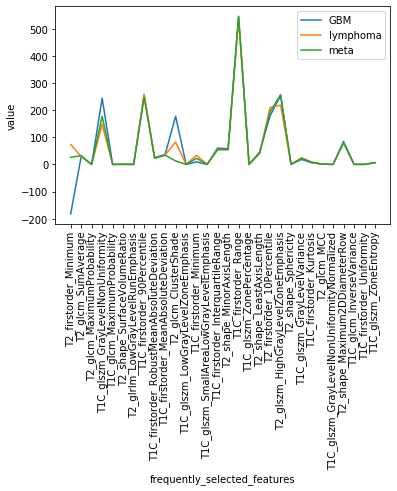

In [ ]:

alldata_GBM=X_train.loc[X_train['target']=='GBM',:].iloc[:, 0:186]
alldata_lymphoma=X_train.loc[X_train['target']=='lymphoma',:].iloc[:, 0:186]
alldata_meta=X_train.loc[X_train['target']=='meta',:].iloc[:, 0:186]

frequent_features_list=list(frequent_features.iloc[:,0])

GBM_selected_summary=alldata_GBM[frequent_features_list].describe()
lymphoma_selected_summary=alldata_lymphoma[frequent_features_list].describe()
meta_selected_summary=alldata_meta[frequent_features_list].describe()

GBM_selected_summary.to_csv('GBM_selected_summary.csv')
lymphoma_selected_summary.to_csv('lymphoma_selected_summary.csv')
meta_selected_summary.to_csv('meta_selected_summary.csv')

x = frequent_features_list
G = GBM_selected_summary.loc['mean']
L = lymphoma_selected_summary.loc['mean']
M = meta_selected_summary.loc['mean']

plt.plot(x, G, label='GBM')
plt.plot(x, L, label='lymphoma')
plt.plot(x, M, label='meta')
plt.xlabel('frequently_selected_features')
plt.ylabel('value')
plt.legend()
plt.xticks(rotation=90)
plt.show()